In [1]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:500px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:500px; }</style>")

# Sensor Gen Distribution - CUDA accelerated

While it is possible to construct new Gen distributions by combining already defined ones, this approach, while offering flexibility and ease of implementation, may come at the cost of performance. In order to address this potential drawback, Gen provides the capability to define custom Gen distributions by implementing the methods of the Distribution API.

We will write a CUDA accelerated custom Gen distribution based on a 2D version of the 3DP3-likelihood, so we can enhance the robot's ability to perceive its surroundings with even greater efficiency.

We also write a version that enables us to sample depth images and not point clouds....

The main functions we export are:
- `get_2d_mixture_components`
- `sensor_logpdf`
- `sensordist_2dp3`
- ...


In [1]:
using Markdown
# This is a fix for vscode, because it doesn't like 
# julia docstrings for whatever reason, and throws a `Katex` error.
Base.show(io::IO, ::MIME"text/latex", md::Markdown.MD) = plain(io, md)

In [2]:
push!(LOAD_PATH, "../src");
include("../src/pose.jl")
include("src/house_expo_data.jl");
include("../src/cuda_raycaster_line_map_b.jl")

Loading data from `../data/data_4.jld2`, and
populating Main namespace with variables:

_segs      Vector{Segment}
_boxes     Vector{Segment}
_center    Vector{Float64}
_xs        Vector{Vector{Float64}}
_hds       Vector{Float64}
_ps        Vector{Pose}
_dxs       Vector{Vector{Float64}}
_dhds      Vector{Float64}
_us        Vector{Control}
_T         Int64


In [3]:
#nbx --fname=src/sensor_distribution.jl
push!(LOAD_PATH, "../src");
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src");
using BenchmarkTools
using CUDA
using Gen
using MyUtils 
using MyCudaUtils # contains _cuda[] and cuda_grid
using GenDistributionZoo: diagnormal 
using Test

In [4]:
typeof(DeviceArray(rand(2,10))),
_cuda[]

(CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}, true)

We start off with a couple of functions that we need broadcastable versions of: 
 - `polar_inv`, a CUDA version of the invererse of polar coordinate transformation.
 - `gaussian_logpdf`, a broadcastable Gaussian logpdf.
 - `logsumexp_slice`, a version of `logsumexp` that can be applied along a dimension.

In [5]:
#nbx
MyUtils.polar_inv(z::CuArray, a::CuArray) = cat(z.*cos.(a), z.*sin.(a), dims=ndims(a)+1);

Normal Distribution: $N(x; \mu, \sigma) = \frac {1}{\sigma {\sqrt {2\pi }}} e^{-{\frac {1}{2}}\left({\frac {x-\mu }{\sigma }}\right)^{2}}$

In [6]:
#nbx
"""
```julia
    log_p = gaussian_logpdf(x, mu, sig)
````
Broadcastable Gaussian logpdf -- benchmarked in `33 - CUDA Accelerated Gen Distributions`.
"""
function gaussian_logpdf(x, mu, sig)
    d = (x .- mu).^2 ./ sig.^2
    log_p = - log.(sig) .- log(sqrt(2π)) .- 1/2 * d
    return log_p
end;

Just a quick reality check that we did not mess anything up in the definition above.

In [13]:
@testset "Gaussian reality check" begin 
for i=1:100
    x   = rand()
    mu  = rand()
    sig = rand()
    
    @test isapprox(logpdf(normal,  x, mu, sig), 
                   gaussian_logpdf(x, mu, sig))
    @test gaussian_logpdf(x, Inf, 1.0)   == -Inf
    @test gaussian_logpdf(Inf, 0.0, 1.0) == -Inf
end 
end;

Test Summary:          | Pass  Total  Time
Gaussian reality check |  300    300  0.0s


CDF of Normal Distribution: $\Phi(x; \mu, \sigma) =  {\frac {1}{2}}\left[1+\operatorname {erf} \left({\frac {x-\mu }{\sigma {\sqrt {2}}}}\right)\right]$

In [14]:
#nbx
using SpecialFunctions: erf
"""
```julia
    log_c = gaussian_logcdf(x, mu, sig)
````
Broadcastable Gaussian logcdf
"""
function gaussian_logcdf(x, mu, sig)
    d = (x .- mu)./(sig.*sqrt(2))
    log_c = - log(2) .+ log.(1 .+ erf.(d))
    return log_c
end;

function gaussian_cdf(x, mu, sig)
    d = (x .- mu)./(sig.*sqrt(2))
    return (1 .+ erf.(d))./2
end;

In [15]:
using Distributions: cdf, Normal
x = rand(Normal(0,100))
mu = 0.0
sig = 1.0

@testset "Gaussian CDF reality check" begin 
    for i=1:100
        x = rand(Normal(0,100))
        mu  = rand(Normal(0,100))
        sig = 100*rand()
        @test isapprox(
            gaussian_cdf(x, mu, sig), 
            cdf(Normal(mu, sig), x), atol=1e-9)
    end 
end;


Test Summary:              | Pass  Total  Time
Gaussian CDF reality check |  100    100  0.0s


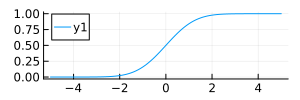

In [16]:
xs = -5:0.1:5
mu  = 0.0
sig = 1.0

# -------------------
plot(xs, exp.(gaussian_logcdf(xs, mu, sig)), size=(300,100))


In [17]:
#nbx
"""
```julia
  logsumexp_slice(x; dims)
```
Applies `logsumexp` along specified dimensions.


Benchmarks
```julia 
x: (2000, 2000)
dims: 2
with `check_inf`
  CPU  >>  49.887 ms (26 allocations: 30.57 MiB)
  CUDA >> 355.932 μs (367 allocations: 19.55 KiB)

without `check_inf`
  CPU  >>  54.482 ms (20 allocations: 30.56 MiB)
  CUDA >>  69.461 μs (142 allocations: 8.06 KiB)
```
"""
function logsumexp_slice(x::Union{CuArray, Array}; dims, check_inf=true)
    c = maximum(x, dims=dims)
    y = c .+ log.(sum(exp.(x .- c), dims=dims))
    
    # Note that if c is -Inf, then y will be NaN.
    if check_inf
        y[c .== -Inf] .= - Inf
    end
    return y
end;

In [18]:
logsumexp([Inf]), 
logsumexp([Inf,1.]),
logsumexp([Inf,-Inf]),
logsumexp([-Inf]), 
logsumexp([-Inf,-Inf]),
logsumexp([-Inf, 1.0])

(NaN, NaN, NaN, -Inf, -Inf, 1.0)

In [19]:
# Todo: make sure we tested all the edge cases 
#       we need (Inf's, NaN's...)
@testset "Logsumexp reality check" begin 
    for _=1:20
        x = rand(10,5)
        @test isapprox(
            logsumexp_slice(x, dims=2),
            log.(sum(exp.(x), dims=2)))
    end
    @test isnan.(logsumexp_slice([Inf; 1.0], dims=1))  == [true]
    @test logsumexp_slice([-Inf; 1.0], dims=1) == [1.0]
    @test logsumexp_slice([-Inf;-Inf], dims=1) == [-Inf]
end;

Test Summary:           | Pass  Total  Time
Logsumexp reality check |   23     23  0.6s


In [20]:
x  = rand(2000, 2000)

function bench_logsumexp(x, dims, check_inf)
    logsumexp_slice(x; dims=dims, check_inf=check_inf)
end

println("x: $(size(x))")
@btime bench_logsumexp($x , 2, true)  samples=3 evals=3;
@btime bench_logsumexp($x , 2, false) samples=3 evals=3;
if _cuda[]
    x_ = CuArray(x);
    @btime bench_logsumexp($x_, 2, true)  samples=3 evals=3;
    @btime bench_logsumexp($x_, 2, false) samples=3 evals=3;
end;

x: (2000, 2000)
  48.870 ms (26 allocations: 30.57 MiB)
  48.785 ms (20 allocations: 30.56 MiB)
  446.873 μs (367 allocations: 19.55 KiB)
  64.304 μs (142 allocations: 8.06 KiB)


## Sliding windows

### CPU

In [21]:
slviews(z,w,s) = ((@view z[i:i+w-1]) for i in 1:s:length(z)-w+1)

function bench_it(n,w,s)
    stack(collect(slviews(1:n,4,1)))
end
@btime bench_it(500,10,1)  samples=3 evals=3;

  19.008 μs (3 allocations: 31.56 KiB)


In [22]:
using IterTools: partition

function bench_it(n,w,s)
    x = partition(1:n, w, s)
    stack(collect.(x))
end
@btime bench_it(500,10,1)  samples=3 evals=3;

  399.109 μs (2466 allocations: 384.28 KiB)


In [23]:
#nbx
import Compat
using PaddedViews

function slw_cpu(x, w ,s=1; wrap=false, fill=true, fill_val=Inf)
    if fill
        y = PaddedView(fill_val, x, size(x) .+ (0,2w), (1,w+1))
    else
        y = PaddedView(fill_val, x, size(x) .+ (0,2w), (1,w+1))
        y = Array(y)
        y[:,1:w] .= x[:,end-w+1:end]
        y[:,end-w+1:end] .= x[:,1:w]
    end
    I = ((@view y[j, i:i+2w]) for j=1:size(y,1), i in 1:s:size(y,2)-2w)
    y = Compat.stack(I)
    return permutedims(y, (2,3,1))
end;


In [24]:
k = 500
n = 500
w = 20

x = rand(k,n)
y = slw_cpu(x,w)

println(size(y))

@btime slw_cpu(x,w)  samples=3 evals=3;

(500, 500, 41)
  232.575 ms (500021 allocations: 207.90 MiB)


### CUDA

In [25]:
#nbx 
# Todo: handle wrap around and padding smarter?
"""
```julia
    slw_kernel!(x, y, w::Int, wrap::Bool, fill::Bool, fill_val::Float64)
```
CUDA kernel to compute sliding windows.
Takes CuArrays of shape `(k,n)` and `(k,n,2w+1)`...
"""
function slw_kernel!(x, y, w::Int, wrap::Bool, fill::Bool, fill_val::Float64)
    
    m = 2*w + 1
    n = size(x,2)

    # Make sure the arrays are 
    # of the right shape
    @assert ndims(x)  == 2
    @assert ndims(y)  == ndims(x) + 1
    @assert size(x,1) == size(y,1)
    @assert size(x,2) == size(y,2)
    @assert size(y,3) == m
    
    # Thread id's
    ix = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    iy = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    iz = (blockIdx().z - 1) * blockDim().z + threadIdx().z
    sx = gridDim().x * blockDim().x
    sy = gridDim().y * blockDim().y
    sz = gridDim().z * blockDim().z
        
    for j_pose = ix:sx:size(y,1), j_obs = iy:sy:size(y,2), j_mix = iz:sz:size(y,3)
        # Transform mixture index in `1:m` 
        # to offsets in `-w:w`
        offset = j_mix-1-w
        
        j = j_obs + offset
        if !fill
            j = mod(j - 1 , n) + 1
            val = x[j_pose, j]
        else
            if 1 <= j <= n
                val = x[j_pose, j]
            else
                if fill
                    val = fill_val
                else
                    j = max(min(j,n),1)
                    val = x[j_pose, j]
                end
            end
        end
        
        # Fill entries of `y`
        @inbounds y[j_pose, j_obs, j_mix] = val
    end
    return
end

"""
```julia
    y_ = slw_cu(x_::CuArray, w::Int; blockdims=(8,8,4), wrap=false, fill=true, fill_val=Inf)
```
CUDA-accelerated function computing sliding windows. 
Takes a CuArray of shape `(k,n)` and returns a CuArray
of shape `(k,n,m)`, where `m = 2w+1`....
"""
function slw_cu(x::CuArray, w::Int; blockdims=(8,8,4), wrap=false, fill=true, fill_val=Inf)
    
    k = size(x, 1)
    n = size(x, 2)
    m = 2*w+1
    
    y = CUDA.ones(k,n,m)
    
    # `cuda_grid` defined in reaycaster file, I also put it in utils
    griddims = cuda_grid((k,n,m), blockdims)
    CUDA.@sync begin
        @cuda threads=blockdims blocks=griddims slw_kernel!(x, y, w, wrap, fill, fill_val)
    end
    
    return y
end;

In [26]:
k = 500
n = 500
w = 20

x  = stack(fill(collect(1.0:n), k))
@time x_ = CuArray(x)

y_ = slw_cu(x_, w, blockdims=(8,8,4), wrap=false, fill=true, fill_val=Inf)
y  = Array(y_);
y[1,:,:]

@btime slw_cu(x_, w, blockdims=(8,8,4), wrap=false, fill=true, fill_val=Inf) samples=3 evals=3;

  0.000281 seconds (4 allocations: 160 bytes)
  855.221 μs (59 allocations: 3.48 KiB)


### Combined

In [27]:
#nbx
"""
    y_ = slw(x_, w::Int; blockdims=(8,8,4), wrap=false, fill=false, fill_val=Inf)

Function computing sliding windows, on the GPU.
Takes a CuArray of shape `(k,n)` and returns an CuArray
of shape `(k,n,m)`, where `m = 2w+1`...
"""
function slw(x_::CuArray, w::Int; blockdims=(8,8,4), wrap=false, fill=false, fill_val=Inf)
    y_ = slw_cu(x_, w; blockdims=blockdims, wrap=wrap, fill=fill, fill_val=fill_val)
    return y_
end;

In [28]:
#nbx
"""
    y = slw(x, w::Int; blockdims=(8,8,4), wrap=false, fill=false, fill_val=Inf)

Function computing sliding windows, either on the CPU or GPU.
Takes an Array of shape `(k,n)` and returns an Array
of shape `(k,n,m)`, where `m = 2w+1`...
"""
function slw(x::Array, w::Int; blockdims=(8,8,4), wrap=false, fill=false, fill_val=Inf)
    # Todo: Is that a good pattern??
    if _cuda[]
        x_ = CuArray(x)
        y_ = slw_cu(x_, w; blockdims=blockdims, wrap=wrap, fill=fill, fill_val=fill_val)
        return Array(y_)
    else
        return slw_cpu(x, w;  wrap=wrap, fill=fill, fill_val=fill_val)
    end
end;

In [29]:
k = 500
n = 500
w = 20

x  = stack(fill(collect(1.0:n), k))
x_ = CuArray(x)

fill_up = true
y′ = slw(x,w; fill=fill_up, fill_val=Inf);
@btime slw(x,w; fill=fill_up, fill_val=Inf) samples=3 evals=3;
@btime slw(x_,w; fill=fill_up, fill_val=Inf) samples=3 evals=3;

@assert all(y .== y′)

  32.120 ms (67 allocations: 39.10 MiB)
  755.610 μs (29 allocations: 1.59 KiB)


## 2D Sensor Distribution (for point clouds)

### Mixture components

In [30]:
#nbx
# DEPRECIATED
"""
    ỹ_::CuArray = get_ys_tilde_cu(zs_::CuArray, w::Int)    

DEPRECIATED, use `get_2d_mixture_components` instead. 
"""
function get_ys_tilde_cu(zs_::CuArray, as_::CuArray, w::Int; wrap=false, fill=false, fill_val=0.0)   

    zs_tilde_ = slw_cu(zs_, w; blockdims=(8,8,4), wrap=wrap)
    as_tilde_ = slw_cu(reshape(as_,1,:), w; blockdims=(8,8,4), wrap=wrap)
    ys_tilde_ = polar_inv(zs_tilde_, as_tilde_)
    
    return ys_tilde_
end;

In [31]:
#nbx
# Same as above but want to switch 
# to different name going forward
"""
```julia
    ỹ_::CuArray = get_2d_mixture_components(z_::CuArray, a_::CuArray, w::Int; 
                                            wrap=false, fill=true, 
                                            fill_val_z=Inf, fill_val_a=Inf)
```
Computes the 2d mixture components for the "2dp3" likelihood from a family 
depth scans `z_` along angles `a_`, and with a filter radius of `w`.

Arguments:
 - `z_`:    Range measurements `(k,n)`
 - `a_`:    Angles of measuremnts `(n,)`
 - `w`:     Filter window size

Returns:
 - `ỹ_`: CuArray of shape `(k, n, m, 2)`, where `m=2w+1`
"""
function get_2d_mixture_components(z_::CuArray, a_::CuArray, w::Int; 
                                   wrap=false, fill=true, fill_val_z=Inf, fill_val_a=0.0)
    
    a_ = reshape(a_,1,:)
    
    z̃_ = slw_cu(z_, w; blockdims=(8,8,4), wrap=wrap, fill=fill, fill_val=fill_val_z)
    ã_ = slw_cu(a_, w; blockdims=(8,8,4), wrap=wrap, fill=fill, fill_val=fill_val_a)
    ỹ_ = polar_inv(z̃_, ã_)
    
    # Handle Inf's and NaN
    # Todo: Where were the NaNs coming from again? cos(Inf)?
    ỹ_[isnan.(ỹ_)] .= Inf

    return ỹ_
end;

In [32]:
#nbx
"""
```julia
    ỹ::Array = get_2d_mixture_components(z::Array, a::Array, w::Int; 
                                            wrap=false, fill=true, 
                                            fill_val_z=Inf, fill_val_a=Inf)
```
Computes the 2d mixture components for the "2dp3" likelihood from a family 
depth scans `z` along angles `a`, and with a filter radius of `w`.

Arguments:
 - `z`:    Range measurements `(k,n)`
 - `a`:    Angles of measuremnts `(n,)`
 - `w`:     Filter window size

Returns:
 - `ỹ`: Array of shape `(k, n, m, 2)`, where `m=2w+1`
"""
function get_2d_mixture_components(z::Array, a::Array, w::Int; 
                                   wrap=false, fill=true, 
                                   fill_val_z=Inf, fill_val_a=0.0)
    
    # Todo: Is that a good pattern??
    if _cuda[]
        z_ = CuArray(z)
        a_ = CuArray(a)
        ỹ_ = get_2d_mixture_components(z_, a_, w; 
                                        wrap=wrap, fill=fill, 
                                        fill_val_z=fill_val_z, fill_val_a=fill_val_a)
        return Array(ỹ_)
    else
        a = reshape(a,1,:)
        z̃ = slw_cpu(z, w; blockdims=(8,8,4), wrap=wrap, fill=fill, fill_val=fill_val_z)
        ã = slw_cpu(a, w; blockdims=(8,8,4), wrap=wrap, fill=fill, fill_val=fill_val_a)
        ỹ = polar_inv(z̃, ã)
    
        # Handle Inf's and NaN
        # Todo: Where were the NaNs coming from again? cos(Inf)?
        ỹ[isnan.(ỹ)] .= Inf

        return ỹ
    end
end;

### 2dp3 Likelihood 

In [33]:
#nbx
"""
```julia
    log_ps, ptw = sensor_logpdf(x, ỹ, sig, outlier, outlier_vol=1.0; return_pointwise=false)
```
Evaluates an observation `x` under the 2dp3 likelihood with <br/>
a family of mixture components `ỹ` and parameters `sig`, `outlier`, and `outlier_vol`.

Arguments:
 - `x`:  Observation point cloud `(n,2)`
 - `ỹ`: Family of mixture components `(k,n,m,2)`
 - ...

Returns:
 - `log_ps`: Log-probs `(k,)`
 - `ptw`:    Pointwise log-probs for each observation point `(k,n)`
"""
function sensor_logpdf(x, ỹ, sig, outlier, zmax; return_pointwise=false, return_outliermap=false) 
    @assert size(x,1) == size(ỹ,2)

    k = size(ỹ,1)
    n = size(ỹ,2)
    m = size(ỹ,3)
    x = reshape(x, 1, n, 1, 2)
    
    # Inlier probability (Gaussian mixtures).
    #   Compute 1D Gaussians (k,n,m,2)
    #   Convert to 2D gausians (k,n,m,1)
    #   Convert to mixture `gm` of m 2D gausians (k,n,1,1)
    log_p = gaussian_logpdf(x, ỹ, sig)
    log_p = sum(log_p, dims=4)
    log_p = logsumexp_slice(log_p .- log(m), dims=3)

    # Outlier probability 
    # and outlier map
    log_out = - log(zmax)
    outliermap = nothing
    if return_outliermap
        outliermap = log(1 - outlier) .+ log_p .< log(outlier) .+ log_out
    end

    # Convert to mixture of `gm` and `outlier` (k,n,1,1)
    log_p = log.((1 .- outlier).*exp.(log_p) .+ outlier.*exp.(log_out))
    
    # If we don't need pointwise logprobs
    # we can save us the time and space to copy
    pointwise = nothing
    if return_pointwise
        pointwise = dropdims(log_p, dims=(3,4))
    end

    # Convert to product of mixtures (k,1,1,1)
    log_p = sum(log_p, dims=2)
    log_p = dropdims(log_p, dims=(2,3,4))

    return log_p, pointwise
end
# Todo: Make sure we handle Inf's in y correctly --
#       that might come from sliding window fills? 

# Backwards compatibility -- 
# Same as `sensor_logpdf` above
"""
DEPRECIATED, use `sensor_logpdf` instead.
"""
function sensor_smc_logpdf_cu(x, y, sig, outlier, outlier_vol; return_pointwise=false)
    return sensor_logpdf(x, y, sig, outlier, outlier_vol; return_pointwise=return_pointwise)
end;

In [34]:
k = 2
n = 3
m = 3

x   = rand(n,2)
ys  = rand(k,n,m,2)

# Insert some Inf's, that might come 
# from sliding window fills. 
ys[1,:,:,:] .= Inf

x_  = DeviceArray(x)
ys_ = DeviceArray(ys)

sig         = 1.0
outlier     = 0.1
outlier_vol = 10.0

log_ps , ptw  = sensor_logpdf(x , ys , sig, outlier, outlier_vol; return_pointwise=true)
log_ps_, ptw_ = sensor_logpdf(x_, ys_, sig, outlier, outlier_vol; return_pointwise=true)

@assert isapprox(log_ps, Array(log_ps_))
@assert isapprox(minimum(ptw[1,:]), log(outlier/outlier_vol))


### Distribution

In [35]:
#nbx
struct SensorDistribution2DP3 <: Distribution{Vector{Vector{Float64}}} 
end

"""
```julia
    x = sensordist_cu(ỹ_::CuArray, sig, outlier, outlier_vol=1.0)::Vector{Vector{Float64}}
```
Distribution from the 2dp3-likelihood. Takes 2d-mixture components `ỹ_` and 
samples a vector `x` of 2d points.

Arguments:
 - `ỹ_`: 2d-mixture components `(n,m,2)`
 - ...
Returns:
- `x`: Observation vector of 2d points.
"""
const sensordist_2dp3 = SensorDistribution2DP3()

function Gen.logpdf(::SensorDistribution2DP3, x, ỹ_::CuArray, sig, outlier, outlier_vol=1.0)
    n = size(ỹ_, 1)
    m = size(ỹ_, 2)
    
    x_ = CuArray(stack(x))
    ỹ_ = reshape(ỹ_, 1, n, m, 2) 
    
    log_p, = sensor_logpdf(x_, ỹ_, sig, outlier, outlier_vol) # CuArray of length 1
    return CUDA.@allowscalar log_p[1]
end

function Gen.logpdf(::SensorDistribution2DP3, x, ỹ::Array, sig, outlier, outlier_vol=1.0)
    n = size(ỹ, 1)
    m = size(ỹ, 2)

    x = stack(x)
    ỹ = reshape(ỹ, 1, n, m, 2) 
    
    log_p, = sensor_logpdf(x, ỹ, sig, outlier, outlier_vol) # Array of length 1
    return log_p[1]
end

# Todo: Speed up sampling, the Gen plug-and-play version is 
#       faster when sampling. Slow at evaluation.
function Gen.random(::SensorDistribution2DP3, ỹ_::CuArray, sig, outlier, outlier_vol=1.0)
    n = size(ỹ_,1)
    m = size(ỹ_,2)
    
    # Sample an observation point cloud `x`
    x = Vector{Float64}[]
    for i=1:n
        if bernoulli(outlier)
            # Todo: Change that to a uniform distribution, e.g. over a  
            #       circular area with radius `zmax`.
            x_i = [Inf;Inf]
        else
            j   = rand(1:m)
            y   = Array(ỹ_[i,j,:])
            x_i = diagnormal(y, [sig;sig])

        end
        push!(x, x_i)
    end
    
    return x
end

function Gen.random(::SensorDistribution2DP3, ỹ::Array, sig, outlier, outlier_vol=1.0)
    n = size(ỹ,1)
    m = size(ỹ,2)
    
    # Sample an observation point cloud `x`
    x = Vector{Float64}[]
    for i=1:n
        if bernoulli(outlier)
            # Todo: Change that to a uniform distribution, e.g. over a  
            #       circular area with radius `zmax`.
            x_i = [Inf;Inf]
        else
            j   = rand(1:m)
            y   = ỹ[i,j,:]
            x_i = diagnormal(y, [sig;sig])

        end
        push!(x, x_i)
    end
    
    return x
end;

(D::SensorDistribution2DP3)(args...) = Gen.random(D, args...)

# TODO: Add output and arg grads.
Gen.has_output_grad(::SensorDistribution2DP3)    = false
Gen.has_argument_grads(::SensorDistribution2DP3) = (false, false);

In [36]:
n = 500
m = 41

ys  = rand(n,m,2)
ys_ = DeviceArray(ys)

sig         = 1.0
outlier     = 0.1
outlier_vol = 10.0
args = (ys_, sig, outlier, outlier_vol)
x = sensordist_2dp3(args...)
logpdf(sensordist_2dp3, x, args...)

println("y_: $(size(ys))")
@btime logpdf(sensordist_2dp3, x, args...) samples=3 evals=3;

y_: (500, 41, 2)
  471.473 μs (598 allocations: 55.67 KiB)


Benchmark (GPU)
```julia
y_: (500, 41, 2)
  443.054 μs (598 allocations: 56.33 KiB)
```

In [37]:
@doc cast

```julia
    zs = cast(ps, segs; fov=2π, num_a::Int=361, zmax::Float64=Inf)
```

Computes depth measurements `zs` with respect to a family of stacked poses `ps` and family of stacked line segments `segs` along a fixed number `num_a` of equidistantly spaced angles in the field of view `fov`.

If a CUDA supported GPU is available we run a GPU accelerated version.

Arguments:

  * `ps`: Stacked poses `(k, 3)`
  * `segs`: Stacked line segments `(n, 4)`
  * ...

Returns:

  * `zs`: Depth measurements in the field of view `(k, num_a)`


In [65]:
_fov = π
_num_a = 100
_zs = cast(stack(Vector.(_ps)), stack(Vector.([_segs;_boxes])); fov=_fov, num_a=_num_a);
_zs = unstack(_zs)

_zs_appr = cast(stack(Vector.(_ps)), stack(Vector.(_segs)); fov=_fov, num_a=_num_a);
_zs_appr =unstack(_zs_appr)

_as = create_angles(_fov, _num_a);
_ys = polar_inv.(_zs, [_as]);
_ys_appr = polar_inv.(_zs_appr, [_as]);

0


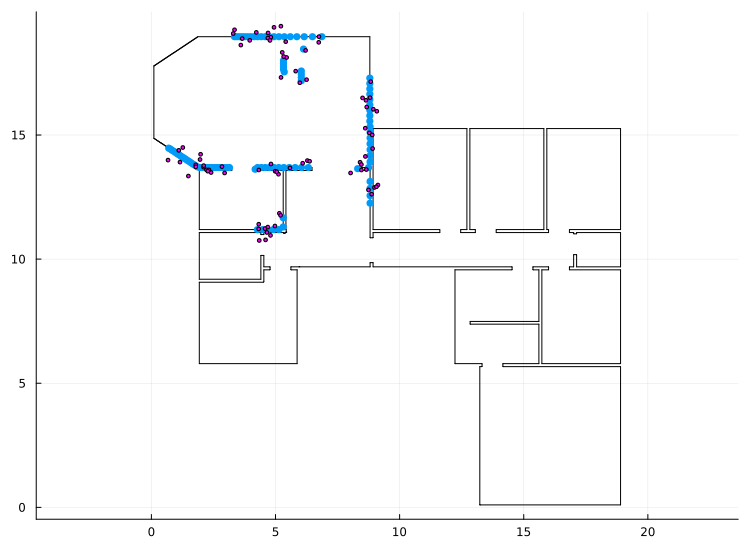

In [62]:
t = 2
zs_ = DeviceArray(stack(_zs[[t]]))
as_ = DeviceArray(_as);

w           = 20
sig         = 0.2
outlier     = 0.1
outlier_vol = 100.


ỹ_ = get_2d_mixture_components(zs_, as_, w; wrap=false, fill=true, 
                                            fill_val_z=Inf, fill_val_a = 0.0);

println(sum(isnan.(ỹ_)))

xs = [sensordist_2dp3(ỹ_[1,:,:,:], sig, outlier, outlier_vol) for i=1:1]
xs = reduce(vcat, xs)

# ----------------
mypl = plot(size=(750,550), aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)
scatter!(_ys[t].*_ps[t], markerstrokewidth=0, c=col[1], label="Reference (Map)")
args = (
    markersize=2, 
    alpha=1., 
    markerstrokewidth=1,
    c=:magenta
)
scatter!(xs.*_ps[t]; args..., label="Samples")
display(mypl)

## 1D Sensor Distribution

TDOD: THIS IS BROKEN I THINK

### 1D Mixture

In [41]:
#nbx
"""
```julia
    ỹ_, w̃_ = get_1d_mixture_components(z_, a_, w, sig; 
                                       wrap=false, fill=true, 
                                       fill_val_z=Inf, fill_val_a=Inf)
```
Computes the 1d mixture components and their weights for the "2dp3" likelihood 
(or rather for the induced line distributions) from depth measurements `z_` 
along angles `a_`, and with a filter radius of `w`.

Arguments:
 - `z_`: Range measurements `(k,n)`
 - `a_`: Angles of measuremnts `(n,)`
 - `w``: Filter window radius

Returns:
 - `ỹ_`: 1d mixture components `(k, n, m)`, where `m2w+1`
 - `w̃_`: 1d mixture weights `(k, n, m)`, where `m2w+1`
"""
function get_1d_mixture_components(z_, a_, w, sig; 
                                   wrap=false, fill=true, 
                                   fill_val_z=Inf, fill_val_a=0.0)
                                   
    a_ = reshape(a_,1,:)
    z̃_ = slw(z_, w; blockdims=(8,8,4), wrap=wrap, fill=fill, fill_val=fill_val_z)
    ã_ = slw(a_, w; blockdims=(8,8,4), wrap=wrap, fill=fill, fill_val=fill_val_a)
    
    # We compute the projection `ỹ` of the 2d mixtures onto 
    # the ray through each pixel and their distance `d̃` to the rays.
    #
    # Note that the embedded point is of the form `[z*cos(a), z*cos(a)]` and 
    # the projections are given by the dot products with the x- and y-axis.
    ã_ = π/2 .- ã_ .+ a_
    d̃_ = z̃_ .* cos.(ã_)
    ỹ_ = z̃_ .* sin.(ã_)
    
    # Handle Inf's and NaN
    d̃_[isnan.(d̃_)] .= Inf
    ỹ_[isnan.(ỹ_)] .= Inf

    # Compute normalized mixture weights
    w̃_ = gaussian_logpdf(d̃_, 0.0, sig)
    w̃_ = w̃_ .- logsumexp_slice(w̃_, dims=3)

    return ỹ_, w̃_
end;

In [49]:
t   = 2
zs_ = CuArray(stack([_zs[t]]))
as_ = CuArray(_as);

w       = 10
sig     = 0.1
outlier = 0.1
zmax    = 100.

ys_tilde_, ws_tilde_ = get_1d_mixture_components(zs_, as_, w, sig,
                                 wrap=false, fill=true, fill_val_z=Inf, fill_val_a = Inf);

sum(isnan.(ys_tilde_)), 
sum(isnan.(ws_tilde_))

(0, 0)

### 1d Likelihood

In [108]:
#nbx
"""
    log_ps, ptw, outl = sensor_logpdf_1d(z, ỹ, w̃, sig, outlier, outlier_vol; return_pointwise=false, return_outliermap=false)

Evaluates an depth measurement `z` under the 2dp3 likelihood with <br/>
a family of 1d mixture components `ỹ` and their weights ` w̃` and <br/>
parameters `sig`, `outlier`, and `outlier_vol`.

Arguments:
    - `z`:  Depth measurements `(n,)`
    - `ỹ`: Family of 1d-mixture components `(k,n,m)`
    - `w̃`: Family of 1d-mixture weights `(k,n,m)`
    - ...

Returns:
    - `log_ps`: Log-probs `(k,)`
    - `ptw`:   Pointwise log-probs for each observation point `(k,n)`
    - `outl`:  Pointwise outlier map for each observation point `(k,n)`
"""
function sensor_logpdf_1d(z, ỹ, w̃, sig, outlier, zmax; return_pointwise=false, return_outliermap=false)
    
    z = clamp.(z, 0.0, zmax)
    # Inlier probability.
    #   Compute the Gaussian log-probabilities, 
    #   truncate at zero and zmax, and
    #   from the mixture.
    log_p   = gaussian_logpdf(z, ỹ, sig)
    log_p .-= log.(gaussian_cdf(zmax, ỹ, sig) .- gaussian_cdf(0.0, ỹ, sig))
    log_p   = logsumexp_slice(log_p .+ w̃, dims=3)
    log_p   = dropdims(log_p, dims=3)

    # Outlier probability (here uniform)
    # and outlier map
    log_out = - log.(zmax)
    outl = nothing
    if return_outliermap
        outl = log(1 - outlier) .+ log_p .< log(outlier) .+ log_out
    end

    # Mixture of inlier and outlier probability
    log_p = log.((1 .- outlier).*exp.(log_p) .+ outlier*exp.(log_out))

    # Pointwise log-probabilities
    ptw = nothing
    if return_pointwise
        ptw = log_p
    end

    log_p = sum(log_p, dims=2)
    log_p = dropdims(log_p, dims=2)

    return log_p, ptw, outl
end;

(1,)(1, 100)(1, 100)


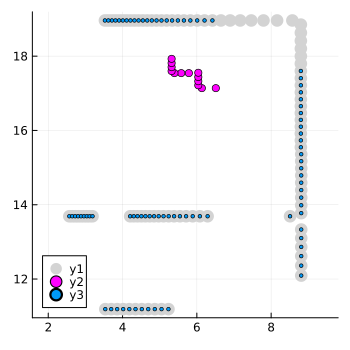

In [109]:
t = 3

z1_ = CuArray(stack([_zs_appr[t]]))
z2_ = CuArray(stack([_zs[t]]))
as_ = CuArray(_as);

w       = 10
sig     = 0.05
outlier = 0.1
zmax    = 100.

ỹ_, w̃_ = get_1d_mixture_components(z1_, as_, w, sig;
                                    wrap=false, fill=true, fill_val_z=Inf, fill_val_a = 0.0);

log_p, ptw, outl = sensor_logpdf_1d(z2_, ỹ_, w̃_, sig, outlier, zmax; 
                                    return_pointwise=true, return_outliermap=true);

log_p = Array(log_p)
ptw   = Array(ptw)
outl  = Array(outl);
cs = peak_to_peak(ptw[1,:])

println(size(log_p), size(ptw), size(outl))

# # ----------------
mypl = plot(size=(350,350), aspect_ratio=:equal)

scatter!(_ys_appr[t].*_ps[t], markerstrokewidth=0, c=:lightgray, markersize=7, label="Map")
scatter!(_ys[t][outl[1,:]].*_ps[t], markerstrokewidth=1, c=:magenta, markersize=4, label="Outlier")
scatter!(_ys[t][.!outl[1,:]].*_ps[t], markerstrokewidth=1, c=col[1], markersize=2, label="Inlier")
# x = Vector{Float64}[]
# v = Float64[]
# for i=1:2:361
#     x = vcat(x, [polar_inv(z,_as[i]) for z in zs[:,i]])
#     v = vcat(v, ptw[:,i])
# end
# println(minimum(v))
# perm = sortperm(v)
# scatter!(x[perm], zcolor=v[perm], color=:viridis, markerstrokewidth=0, markersize=2)
# mypl

### Distribution

In [ ]:
#nbx
struct SensorDistribution1d_CUDA <: Distribution{Vector{Float64}}
end

"""
    z::Vector{Float64} = sensordist1d_cu(ỹ, w̃, sig, outlier, outlier_vol=1.0)

Restricted distribution from the 2dp3-likelihood. 
Takes 1d-mixture components `ỹ` and their weights `w̃`,  and 
samples a vector `z` of depth values.

Arguments:
 - `ỹ`: 1d-mixture components `(n,m)`
 - `w̃`: 1d-mixture weights `(n,m)`
 - ...
Returns:
 - `z`: Observation vector of depth values `(n,)`
"""
const sensordist1d_cu = SensorDistribution1d_CUDA()

# Todo:
function Gen.logpdf(::SensorDistribution1d_CUDA, z, ỹ_, w̃_, sig, outlier, outlier_vol=1.0)
    n = size(ỹ, 1)
    m = size(ỹ, 2)
    
    z_ = CuArray(z)
    ỹ_ = reshape(ỹ_, 1, n, m) 
    w̃_ = reshape(w̃_, 1, n, m) 
    
    log_p, = sensor_logpdf_1d(z_, ỹ_, w̃_, sig, outlier, outlier_vol) # CuArray of length 1
    return CUDA.@allowscalar log_p[1]
end

function Gen.random(::SensorDistribution1d_CUDA, ỹ_, w̃_, sig, outlier, outlier_vol=1.0)
    n = size(ỹ_,1)
    m = size(ỹ_,2)
    
    # Sample an observation point cloud `x`
    z = Float64[]
    for i=1:n
        if bernoulli(outlier)
            # Todo: Change that to a uniform distribution using `zmax`.
            z_i = Inf
        else
            j   = categorical(exp.(w̃_[i,:]) )
            z_i = normal(ỹ_[i,j], sig)
        end
        push!(z, z_i)
    end
    
    return z
end

(D::SensorDistribution1d_CUDA)(args...)             = Gen.random(D, args...)
Gen.has_output_grad(::SensorDistribution1d_CUDA)    = false
Gen.has_argument_grads(::SensorDistribution1d_CUDA) = (false, false);

In [ ]:
t = 1_050

zs_ = CuArray(stack([_zs[t]]))
as_ = CuArray(_as);

w           = 20
sig         = 0.2
outlier     = 0.1
outlier_vol = 100.

ỹ_, w̃_, = get_1d_mixture_components(zs_, as_, w, sig,
                                    wrap=false, fill=true, fill_val_z=Inf, fill_val_a = Inf);
ỹ, w̃ = Array(ỹ_), Array(w̃_)

z = sensordist1d_cu(ỹ[1,:,:], w̃[1,:,:], sig, outlier, outlier_vol)

# ----------------
mypl = plot(size=(600,200))
plot!(_zs[t], c=col[1], linewidth=12, alpha=0.25, label="Reference (Map)")
plot!(z, c=:magenta, marker=:o, markersize=2, label="Sample")
display(mypl)

In [ ]:
# ----------------
mypl = plot(size=(750,550), aspect_ratio=:equal, ylim=(-5,5))
scatter!(_ys_inf[t], markerstrokewidth=0, c=col[1], markersize=5, label="Reference (Map)")

args = (
    markersize=2, 
    alpha=1., 
    markerstrokewidth=1,
    c=:magenta
)
step = 5
scatter!(polar_inv(z[1:step:end], _as[1:step:end]); args..., label="Samples")
for i=1:30
    z = sensordist1d_cu(ỹ[1,:,:], w̃[1,:,:], sig, outlier, outlier_vol)
    scatter!(polar_inv(z[1:step:end], _as[1:step:end]); args..., label=nothing)
end
display(mypl)